In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.special import erf

In [4]:
kb = utils.kb
SI2ev = utils.SI2ev
ev2SI = 1 / (utils.SI2ev)
A = 4 * np.pi * (83.5e-9)**2

In [5]:
T = 293

# def fmb(mg, v, T):
#     return (4 * np.pi * v**2) * (mg / (2*np.pi*kb*T))**(3/2) * np.exp(-1 * (mg*v**2 / (2*kb*T)))

def fmb(dp, mg, vbar):
    return np.exp(-1 * dp**2 / (8 * mg**2 * vbar**2)) / np.sqrt(2 * np.pi * vbar**2)

def xi(x):
    return np.sqrt(np.pi) * x * (1 - 2/(x**2)) * erf(x/2) * np.exp(-x**2 / 8) + 2 * np.exp(-3 * x**2 / 8)

def dgamma_dp(pp_kev, A, mg_amu, p_mbar, alpha, T=293):
    pp = pp_kev * 1000 * ev2SI
    mg = mg_amu * 1.660538921e-27
    p_pascal = p_mbar * 100
    ng = p_pascal / (kb * T)
    
    vbar = np.sqrt(kb * T / mg)
    
    # rate = (ng * A * pp / (4 * mg**2)) * fmb(mg, pp/(2*mg), T) * (1 - alpha + alpha * xi(pp/(mg*vbar)))
    rate = (ng * A * pp / (4 * mg**2)) * fmb(pp, mg, vbar) * (1 - alpha + alpha * xi(pp/(mg*vbar)))
    rate_hz_kev = rate * 1000 * ev2SI  # Hz/keV
    return rate_hz_kev
    

In [6]:
def zeta(a, c, d):
    prefactor = c**2 * d**2

    first_pre = 2 * a * np.sqrt(c**2 + d**2)
    first_0 = first_pre * d**2 * np.exp(-0.5 * a**2 / d**2)
    first_1 = first_pre * c**2 * np.exp(-0.5 * a**2 / c**2)

    second_pre = c * d * (a**2 - c**2 - d**2) * np.exp(-0.5 * a**2 / (c**2 + d**2)) * np.sqrt(2 * np.pi)
    second = erf(a * c / (np.sqrt(2) * d * np.sqrt(c**2 + d**2))) + erf(a * d / (np.sqrt(2) * c * np.sqrt(c**2 + d**2)))

    denominator = 2 * (c**2 + d**2)**(5/2)

    return prefactor * ((first_0 + first_1) + second_pre * second) / denominator
    
def dgamma_dp_diffuse(pp_kev, A, mg_amu, p_mbar, tl=293, th=300):
    pp = pp_kev * 1000 * ev2SI      # N s
    mg = mg_amu * 1.660538921e-27   # kg
    
    p_pascal = p_mbar * 100
    ng = p_pascal / (kb * tl)
    print(ng)

    print(ng * A)

    vl = np.sqrt(kb * tl / mg)
    vh = np.sqrt(kb * th / mg)

    rate = ng * A * (1 / np.sqrt(2*np.pi)) * (1 / (vl*vh**2)) * zeta(pp/mg, vl, vh) / mg
    rate_hz_kev = rate / (SI2ev / 1000)
    
    return rate_hz_kev

In [7]:
pp_kev = np.linspace(1, 10000, 10000)

dg_dp_diffuse = dgamma_dp_diffuse(pp_kev, A, 131.3, 1e-11, 293, 2000)
dg_dp = dgamma_dp(pp_kev, A, 131.3, 1e-11, 1, 293)

247200358909.21225
0.02165867636809231


In [21]:
dpp_kev = pp_kev[1] - pp_kev[0]
pp_gauss = np.arange(-2500, 2500, dpp_kev)
gauss_smearing = utils.gauss(pp_gauss, 1, 0, 300)

dg_dp_diffuse_smeared = np.convolve(dg_dp_diffuse, gauss_smearing, 'same') / np.sum(gauss_smearing)

Text(0.5, 1.0, 'Isotropic readout')

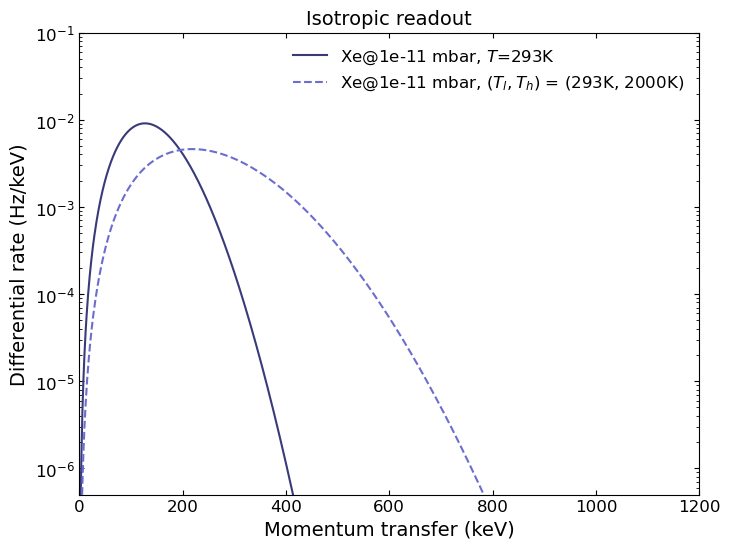

In [22]:
plt.subplots(figsize=(8, 6))
plt.plot(pp_kev, dg_dp, label='Xe@1e-11 mbar, $T$=293K')
plt.plot(pp_kev, dg_dp_diffuse, '--', label='Xe@1e-11 mbar, ($T_l, T_h$) = (293K, 2000K)')
# plt.plot(pp_kev, dg_dp_diffuse_smeared)

plt.legend(frameon=False, fontsize=12)
plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 1200)
plt.ylim(5e-7, 0.1)
plt.xlabel('Momentum transfer (keV)')
plt.ylabel('Differential rate (Hz/keV)')
plt.title('Isotropic readout')

# plt.savefig('xe_isotroon.pdf', dpi=600)

In [21]:
def dgamma_dp_silica_chunks(pp_kev, A, mg_amu, ng, delta_e_mev, th=1500):
    delta_e = delta_e_mev / 1000 * 1.602176634e-19  # N s^2
    pp = pp_kev * 1000 * ev2SI      # N s
    mg = mg_amu * 1.660538921e-27   # kg
    
    vh = np.sqrt(kb * th / mg)

    rate = ng * A * (1 / (vh**2)) * np.exp(-1 * (pp + delta_e / (vh**2) / mg)**2 / (2 * vh**2)) / mg
    rate_hz_kev = rate / (SI2ev / 1000)
    
    return rate_hz_kev

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Isotropic readout')

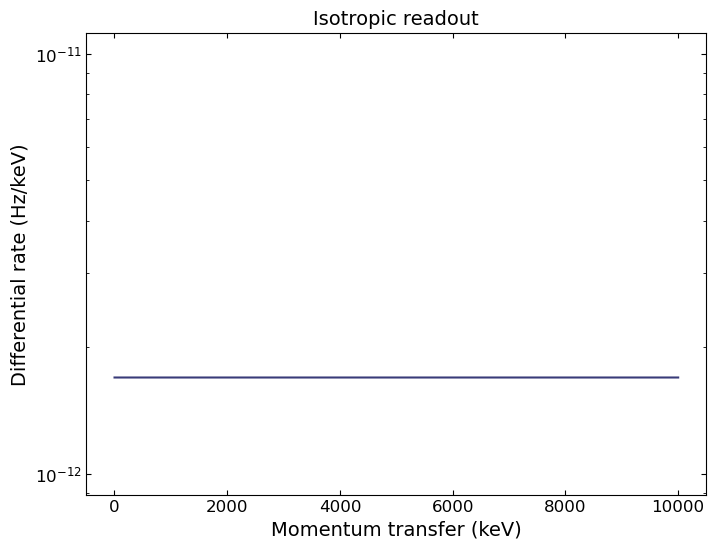

In [24]:
pp_kev = np.linspace(1, 10000, 10000)

dg_dp_silica = dgamma_dp_silica_chunks(pp_kev, A, 44*25, 1000000, 100, 2000)

plt.subplots(figsize=(8, 6))
plt.plot(pp_kev, dg_dp_silica, label='')

plt.legend(frameon=False, fontsize=12)
plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0, 4000)
# plt.ylim(5e-7, 0.1)
plt.xlabel('Momentum transfer (keV)')
plt.ylabel('Differential rate (Hz/keV)')
plt.title('Isotropic readout')


724297051603992.0
63.459921758510475


Text(0.5, 1.0, 'Isotropic readout')

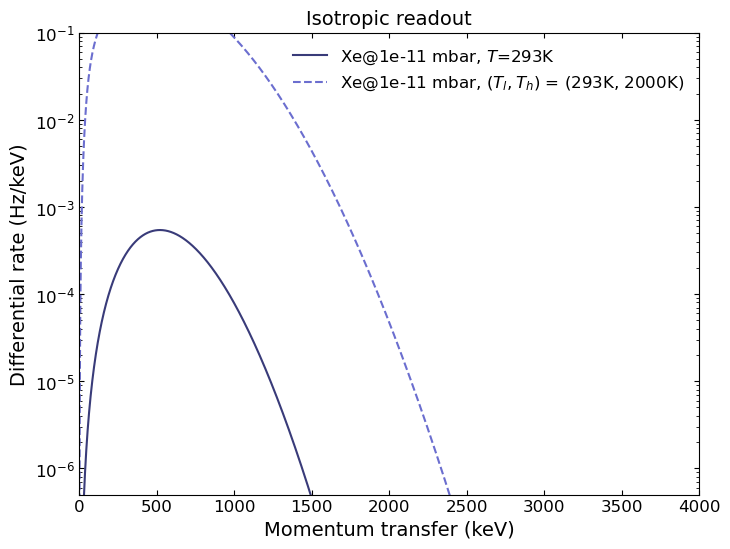

In [25]:
pp_kev = np.linspace(1, 10000, 10000)

dg_dp_diffuse = dgamma_dp_diffuse(pp_kev, A, 44*25, 1e-9, 10, 2000)
dg_dp = dgamma_dp(pp_kev, A, 44*50, 1e-11, 1, 293)

plt.subplots(figsize=(8, 6))
plt.plot(pp_kev, dg_dp, label='Xe@1e-11 mbar, $T$=293K')
plt.plot(pp_kev, dg_dp_diffuse, '--', label='Xe@1e-11 mbar, ($T_l, T_h$) = (293K, 2000K)')
# plt.plot(pp_kev, dg_dp_diffuse_smeared)

plt.legend(frameon=False, fontsize=12)
plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 4000)
plt.ylim(5e-7, 0.1)
plt.xlabel('Momentum transfer (keV)')
plt.ylabel('Differential rate (Hz/keV)')
plt.title('Isotropic readout')

# plt.savefig('xe_isotroon.pdf', dpi=600)

In [36]:
r = 83e-9
r_sio2 = 0.15e-9

4 * np.pi * (r / r_sio2)**2

3847543.42943646